In [1]:
import os
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as T
import torch.nn.functional as F

from ig_pkg.datasets import get_datasets

from ig_pkg.models.generator import get_model
from ig_pkg.models.classifier import get_classifier
from ig_pkg.models.pretrained_models import get_pretrained_model

from ig_pkg.inputattribs.ig import ig
from ig_pkg.inputattribs.baseline_generator import get_baseline_generator

from ig_pkg.misc import process_heatmap, normalize_tensor, convert_to_img, label_to_class, tran, na_imshow

import time
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from ig_pkg.loss.focal_loss import FocalLoss
from ig_pkg.loss.metrics import ArcMarginProduct, AddMarginProduct
import torchvision.models as models

import seaborn as sns

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]


Blur IG - problem

In [2]:

import torch 
from torch.autograd import Variable

def make_perturbation(x, M, sigma):
    lst = [] 
    for i in range(M):
        noise = torch.normal(0, sigma, size=x.size()).to(x.device)
        lst.append(x.clone() + noise.clone())
    return torch.stack(lst)

def smoothgrad(model, x, y, **kwrags):
    M = 25
    sigma = 0.15
    device = x.device
    sigma = sigma * (x.max() - x.min())
    X = make_perturbation(x, M, sigma)
    grads = []
    for i in range(M):
        x = Variable(X[i], requires_grad=True).to(device)
        x = x.unsqueeze(0)
        x.retain_grad()
        model.zero_grad()
        output = model(x)
        score = torch.softmax(output, dim=-1)
        class_score = torch.FloatTensor(x.size(0), output.size()[-1]).zero_().to("cuda")
        class_score[:,y] = score[:,y]
        output.backward(gradient=class_score)
        gradient = (x.grad.data).abs()
        grads.append(gradient.squeeze(0))
    del X

    output = torch.mean(torch.stack(grads, dim=0), dim=0)  # perturbation mean
    output = output.mean(dim=0) # RGB mean
    return output

def smoothgrad_energy(model, x,  **kwrags):
    M = 25
    sigma = 0.15
    device = x.device
    sigma = sigma * (x.max() - x.min())
    X = make_perturbation(x, M, sigma)
    grads = []
    for i in range(M):
        x = Variable(X[i], requires_grad=True).to(device)
        x = x.unsqueeze(0)
        x.retain_grad()
        model.zero_grad()
        output = model(x).sum()
        output.backward()
        gradient = (x.grad.data).abs()
        grads.append(gradient.squeeze(0))
    del X

    output = torch.mean(torch.stack(grads, dim=0), dim=0)  # perturbation mean
    output = output.mean(dim=0) # RGB mean
    return output

def smoothgrad_energy_perturbed(model, x,  **kwrags):
    M = 25
    sigma = 0.15
    device = x.device
    sigma = sigma * (x.max() - x.min())
    X = make_perturbation(x, M, sigma)
    grads = []
    for i in range(M):
        x = Variable(X[i], requires_grad=True).to(device)
        x = x.unsqueeze(0)
        x.retain_grad()
        model.zero_grad()
        output = model(x).sum()
        output.backward()
        gradient = (x.grad.data).abs()
        grads.append(gradient.squeeze(0))
    del X

    output = torch.mean(torch.stack(grads, dim=0), dim=0)  # perturbation mean
    output = output.mean(dim=0) # RGB mean
    return output

In [3]:
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
import saliency.core as saliency 
from matplotlib import pylab as P

data_path="../../../datasets/ILSVRC2012_val/"

_, valid_datasets = get_datasets("imagenet1k", data_path)
valid_dataloader = torch.utils.data.DataLoader(valid_datasets, batch_size=32, shuffle=True, num_workers=2)

transformer = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
def PreprocessImages(images):
    # assumes input is 4-D, with range [0,255]
    #
    # torchvision have color channel as first dimension
    # with normalization relative to mean/std of ImageNet:
    #    https://pytorch.org/vision/stable/models.html
    images = np.array(images)
    images = images/255
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = transformer.forward(images)
    return images.requires_grad_(True)


class_idx_str = 'class_idx_str'

def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    target_class_idx =  call_model_args[class_idx_str]
    output = model(images)
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs


In [10]:
inputs = 0
labels = 0
for i, (inputs, labels) in enumerate(valid_dataloader):



TypeError: 'DataLoader' object is not callable

In [15]:

# Construct the saliency object. This alone doesn't do anthing.
blur_ig = saliency.BlurIG()

blur_ig_mask_3d = blur_ig.GetMask(
  ferrot_tensor.detach().numpy(), call_model_function, {357:'ferrot'}, batch_size=20)

# # Call the visualization methods to convert the 3D tensors to 2D grayscale.
# blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(blur_ig_mask_3d)

# # Set up matplot lib figures.
# ROWS = 1
# COLS = 2
# UPSCALE_FACTOR = 10
# P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# # Render the saliency masks.
# ShowGrayscaleImage(blur_ig_mask_grayscale, title='Blur Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))

RuntimeError: The size of tensor a (224) must match the size of tensor b (3) at non-singleton dimension 1

In [11]:
# n02443484: 40 black-footed_ferret
# n01614925: 398 bald_eagle

data_path = '../../../datasets/ILSVRC2012_val/'

ferrot_dir = os.path.join(data_path, 'val', 'n02443484')
ferrot_idx = os.listdir(ferrot_dir)[29]
ferrot_img = Image.open(os.path.join(ferrot_dir, ferrot_idx))

eagle_dir = os.path.join(data_path, 'val', 'n01614925')
eagle_idx = os.listdir(eagle_dir)[1]
eagle_img = Image.open(os.path.join(eagle_dir, eagle_idx))


transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean = IMAGENET_MEAN, std = IMAGENET_STD),
])

ferrot_tensor = transform(ferrot_img)
eagle_tensor = transform(eagle_img)


In [11]:
# https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [56]:
def fgsm_attack(model, loss, images, labels, eps) :
    
    images = images
    labels = labels
    images.requires_grad = True
            
    outputs = model(images)
    
    model.zero_grad()
    cost = loss(outputs, labels)
    cost.backward()
    
    attack_images = images + eps*images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1)
    
    return attack_images

model.eval()
loss = nn.CrossEntropyLoss()
images = ferrot_tensor.unsqueeze(0)
labels = torch.tensor([359])
eps = 0.05

temp = fgsm_attack(model, loss, images, labels, eps)

1.5089647769927979


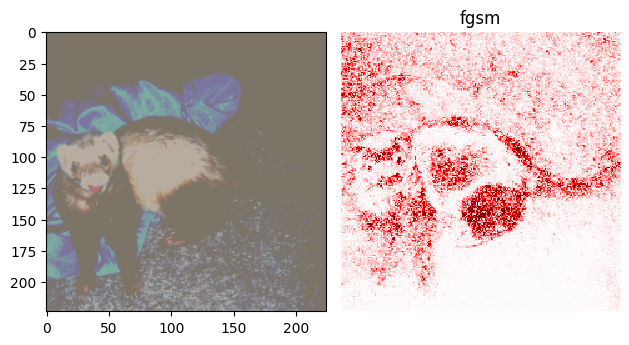

In [71]:
index = 0 
# x,y = valid_datasets[index]
x = ferrot_tensor
y = 359

start_time = time.time()


fig, axes = plt.subplots(1, 2) #, figsize=(2*len(names)//2, 2*2))
axes_flat = axes.flat 
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

ax = next(axes_flat)
ax.imshow(convert_to_img(temp.squeeze(0)))

attr = ig(model, x, y, temp.squeeze(0), device='cpu')
attr, kwargs  = process_heatmap(attr.cpu(), my_cmap)
ax = next(axes_flat)
ax.imshow(attr, **kwargs)
ax.set_title('fgsm')
ax.axis("off")
plt.tight_layout()

print(time.time() - start_time)

0.21243071556091309


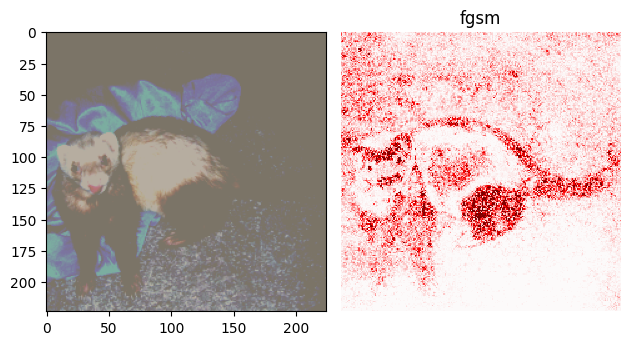

In [70]:
start_time = time.time()

fig, axes = plt.subplots(1, 2) #, figsize=(2*len(names)//2, 2*2))
axes_flat = axes.flat 
my_cmap=plt.cm.seismic(np.arange(plt.cm.seismic.N))

ax = next(axes_flat)
ax.imshow(convert_to_img(temp.squeeze(0)))

attr = ig(model, x, y, temp.squeeze(0), M = 1, device='cpu')
attr, kwargs  = process_heatmap(attr.cpu(), my_cmap)
ax = next(axes_flat)
ax.imshow(attr, **kwargs)
ax.set_title('fgsm')
ax.axis("off")
plt.tight_layout()

print(time.time() - start_time)

tensor(208)


<Axes: >

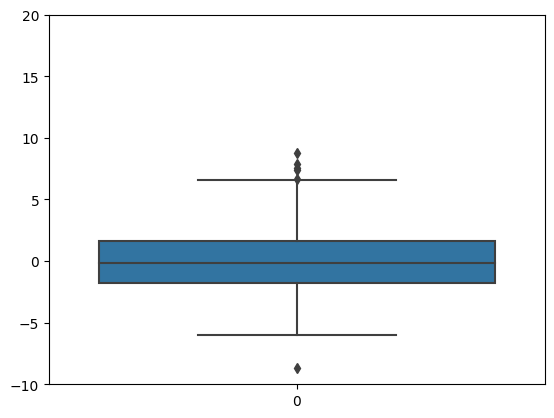

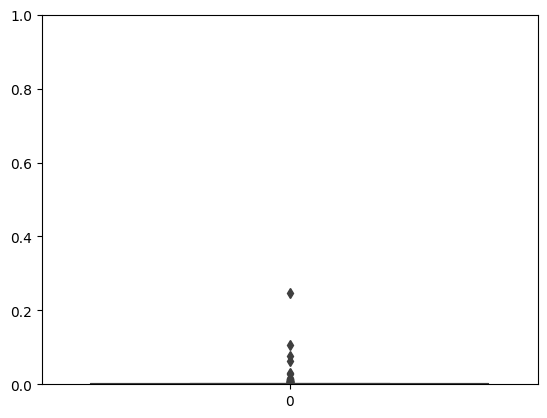

In [68]:
scr = model(temp)
m = nn.Softmax(dim=1)

sft = m(scr)
pre = torch.argmax(scr)
log = scr.detach().numpy()
lg = sft.detach().numpy()
print(pre)
plt.figure()
sns.boxplot(log)
plt.ylim(-10, 20)
plt.figure()
plt.ylim(0, 1)
sns.boxplot(lg)
